In [24]:
# Basic packagess
import pandas as pd
import numpy as np
from scipy import stats 
# Results visualization
import matplotlib.pyplot as plt
import seaborn as sns
# lifelines
from lifelines.datasets import load_waltons
from lifelines import CoxPHFitter,KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines.statistics import logrank_test
from sklearn.preprocessing import  StandardScaler, MinMaxScaler, RobustScaler

def confidence_interval(stats,alpha):
    # confidence intervals
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))
    
all_predictors = [
    "original_firstorder_Energy",
    "original_shape_Compactness",
    "original_glrlm_GrayLevelNonUniformity",
    "wavelet-HLH_glrlm_GrayLevelNonUniformity",
    "original_shape_Volume"]

hugo_predictors = [
    "original_firstorder_Energy",
    "original_shape_Compactness",
    "original_glrlm_GrayLevelNonUniformity",
    "wavelet-HLH_glrlm_GrayLevelNonUniformity"]
hugo_volume = ["original_shape_Volume"]

hugo_outcome = ["Survival.time"]

df1_radiomics= pd.read_csv('./data/raw_GTV-1_only.csv')
df1_clinical = pd.read_csv('./data/Lung1.clinical_Updated_Len.csv')
df1_merge = df1_radiomics.merge(df1_clinical,on = "patient_id")
df1_merge['original_shape_Sphericity'] = df1_merge['original_shape_Sphericity'] **3
df1_merge = df1_merge.rename(index=str,columns={'original_shape_Sphericity':'original_shape_Compactness'})
# dflung1 = df1_merge[hugo_used]
df1_merge = df1_merge.rename(index=str,columns={'Updated.Survival.time':'Survival.time'})
df1_merge = df1_merge.rename(index=str,columns={'Updated.deadstatus.event':'deadstatus.event'})

dflung2 = pd.read_csv('./data/Lung2.clinical_radiomics_GTV_ZW.csv')
dflung2['original_shape_Sphericity'] = dflung2['original_shape_Sphericity'] **3
dflung2 = dflung2.rename(index=str,columns={'original_shape_Sphericity':'original_shape_Compactness'})

### No pre-processing, spearman correlation of 5 features

In [25]:
# df1 = df1_merge[all_predictors]
# df2 = dflung2[all_predictors]
# plt.figure(figsize = (10,8))
# corr1 = df1.corr(method='spearman', min_periods=1)
# ax1=sns.heatmap(corr1,annot=True)
# # corr2 = df2.corr(method='spearman', min_periods=1)
# # ax2=sns.heatmap(corr2,annot=True)
# # plt.savefig('./DLR_result/DLR_Volume/DLR_FeatureCorr_lung1.pdf')
# # plt.savefig('./DLR_result/DLR_Volume/DLR_FeatureCorr_lung2')
# plt.show()

## Data transformation and normalization

In [26]:
df1_merge[all_predictors] = np.log10(df1_merge[all_predictors])
dflung2[all_predictors] = np.log10(dflung2[all_predictors])

# pre-processing
# all features are normalized by using z-score normalization
dflung1_f = df1_merge[all_predictors]
dflung2_f = dflung2[all_predictors]

dflung2[all_predictors] = (dflung2[all_predictors] - dflung2_f.mean(axis=0)) / (dflung2_f.std(axis=0, ddof=0))
# dflung2[all_predictors] = (dflung2[all_predictors] - dflung1_f.mean(axis=0)) / (dflung1_f.std(axis=0, ddof=0))
df1_merge[all_predictors] = (df1_merge[all_predictors] - dflung1_f.mean(axis=0)) / (dflung1_f.std(axis=0, ddof=0))

## Convert survival time to binary (0/1)

In [27]:
dflung1_train = df1_merge[hugo_predictors]
bool_lung1 = df1_merge[hugo_outcome]>=365*2 
TwoyearS_Lung1 = bool_lung1*1
dflung2_validation = dflung2[hugo_predictors]
bool_lung2 = dflung2[hugo_outcome]>=365*2 
TwoyearS_Lung2 = bool_lung2*1

In [28]:
# np.mean(df1_merge[all_predictors])

In [29]:
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import cross_validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import warnings
from scipy import interp
warnings.simplefilter('ignore')

## 2-year survival classification using 4-feature signature

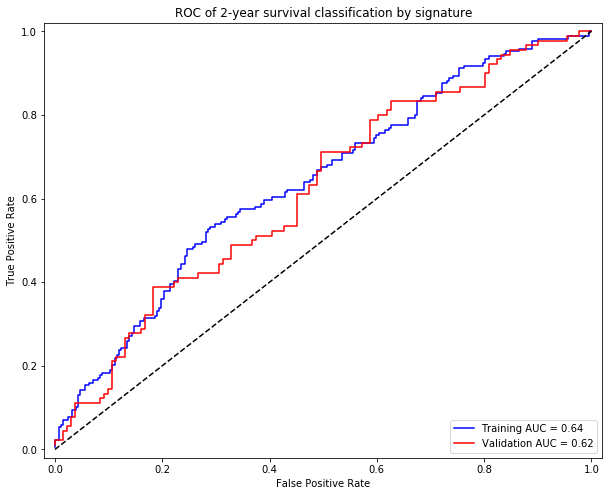

In [30]:
classifier = LogisticRegression()
classifier.fit(dflung1_train,TwoyearS_Lung1)
probs_train = classifier.predict_proba(dflung1_train)
preds_train = probs_train[:,1]
fpr_train, tpr_train, threshold_train = metrics.roc_curve(TwoyearS_Lung1, preds_train)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# ------------------bootstrap 1000 times
# V_outcome_bs = pd.concat([dflung2_validation,TwoyearS_Lung2],axis=1)
# n_bs = 1000 
# n_sample = validation.shape[0]
# AUC_Vbs = []
# for i in range(n_bs):
#     validation_bs = V_outcome_bs.sample(n_sample,replace=True)
#     validation_predictor_bs = validation_bs[hugo_predictors]
#     TwoyearS_lung2bs = validation_bs[hugo_outcome]
#     probs_Vbs = classifier.predict_proba(validation_predictor_bs)
#     preds_Vbs = probs_Vbs[:,1]
#     fpr_Vbs, tpr_Vbs, threshold_Vbs = metrics.roc_curve(TwoyearS_lung2bs, preds_Vbs)
#     roc_auc_Vbs = metrics.auc(fpr_Vbs, tpr_Vbs)
#     AUC_Vbs.append(roc_auc_Vbs)
# AUC_Vbs
# print(np.mean(AUC_Vbs))
# alpha = 0.95
# confidence_interval(AUC_Vbs,alpha)

probs_validation = classifier.predict_proba(dflung2_validation)
preds_validation = probs_validation[:,1]
fpr_validation, tpr_validation, threshold_validation = metrics.roc_curve(TwoyearS_Lung2, preds_validation)
roc_auc_validation = metrics.auc(fpr_validation, tpr_validation)

# method I: plt
import matplotlib.pyplot as plt
plt.figure(figsize = (10,8))
plt.title('ROC of 2-year survival classification by signature')
plt.plot(fpr_train, tpr_train, 'b', label = 'Training AUC = %0.2f' % roc_auc_train)
plt.plot(fpr_validation, tpr_validation, 'r', label = 'Validation AUC = %0.2f' % roc_auc_validation)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.savefig('./DLR_result/DLR_Volume/DLR_TwoyearS_signature.pdf')
plt.show()

## 2-year survival classification using Volume only

In [107]:
Train = df1_merge[hugo_volume]
validation =dflung2[hugo_volume]
V_outcome_bs = pd.concat([validation,TwoyearS_Lung2],axis=1)

classifier = LogisticRegression()
classifier.fit(Train,TwoyearS_Lung1)
probs_train = classifier.predict_proba(Train)
preds_train = probs_train[:,1]
fpr_train, tpr_train, threshold_train = metrics.roc_curve(TwoyearS_Lung1, preds_train)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# ------------------bootstrap 1000 times
# n_bs = 1000 
# n_sample = validation.shape[0]
# AUC_Vbs = []
# for i in range(n_bs):
#     validation_bs = V_outcome_bs.sample(n_sample,replace=True)
#     validation_predictor_bs = validation_bs[hugo_volume]
#     TwoyearS_lung2bs = validation_bs[hugo_outcome]
#     probs_Vbs = classifier.predict_proba(validation_predictor_bs)
#     preds_Vbs = probs_Vbs[:,1]
#     fpr_Vbs, tpr_Vbs, threshold_Vbs = metrics.roc_curve(TwoyearS_lung2bs, preds_Vbs)
#     roc_auc_Vbs = metrics.auc(fpr_Vbs, tpr_Vbs)
#     AUC_Vbs.append(roc_auc_Vbs)
# AUC_Vbs
# print(np.mean(AUC_Vbs))
# alpha = 0.95
# confidence_interval(AUC_Vbs,alpha)

# --------------------------------------
probs_validation = classifier.predict_proba(validation)
preds_validation = probs_validation[:,1]
fpr_validation, tpr_validation, threshold_validation = metrics.roc_curve(TwoyearS_Lung2, preds_validation)
roc_auc_validation = metrics.auc(fpr_validation, tpr_validation)

# method I: plt
import matplotlib.pyplot as plt
plt.figure(figsize = (10,8))
plt.title('ROC of 2-year survival classification by Volume')
plt.plot(fpr_train, tpr_train, 'b', label = 'Training AUC = %0.2f' % roc_auc_train)
plt.plot(fpr_validation, tpr_validation, 'r', label = 'Validation AUC = %0.2f' % roc_auc_validation)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.savefig('./DLR_result/DLR_Volume/DLR_TwoyearS_Volume.pdf')
# plt.show()